<h1 style="font-size:30px;">Deep Learning based Object Detection using MobileNet SSD</h1>

In this chapter, we will discuss how to use Deep Learning based Object Detectors in OpenCV. Faster-RCNN, R-FCN, SSD, and YOLO are among the Object Detection models implemented in OpenCV. 
You can check out the support for various models in the **[Wiki](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV#object-detection)**.

We will discuss the [Single Shot Multibox Detector (SSD)](https://arxiv.org/pdf/1512.02325.pdf) model trained using the [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). Among the SSD based models, there is support for MobileNet and Inception as the backbone CNN. They also provide a script to convert the graph configuration to OpenCV format, so that you may train your own models and use them in OpenCV.

As an example, we will be detecting objects in the following image:

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m15-fruit-vegetable.jpg" alt="Fruit Vegetable">
</center>
<br>

The steps involved in detecting objects using the DNN module are as follows: 
1. Load the model and input image to memory.
1. Detect objects using the forward method of the network.
1. Display the detected objects.


In [1]:
if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/uro596fmm67in3b/AABurDoQj5tS94EgUDQXkcBaa?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
    !pip install --upgrade opencv-contrib-python
else:
    pass

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['image.cmap'] = 'gray'

# 1. Download model

Here we will download the model if it is not present in the local folder. Note: this may take a little while, depending on your internet connection.

In [4]:
modelFile = 'ssd_mobilenet_frozen_inference_graph.pb'
configFile = 'ssd_mobilenet_v2_coco_2018_03_29.pbtxt'
classFile = 'coco_class_labels.txt'

In [5]:
import requests
from os import path

if(not path.exists(modelFile)):
    print('Downloading MobileNet SSD Model.......')
    
    url = 'https://opencv-courses.s3.us-west-2.amazonaws.com/ssd_mobilenet_frozen_inference_graph.pb'

    r = requests.get(url)

    with open(modelFile, 'wb') as f:
        f.write(r.content)

    print('ssd_mobilenet_frozen_inference_graph Download complete!')


ssd_mobilenet_frozen_inference_graph Download complete!


# 2. Read Tensorflow Model
Here, we read the model specified above into memory.

In [6]:
# Read the Tensorflow network
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

## <font style="color:rgb(50,120,229)">Check Class Labels</font>
We check the class labels which will come handy while decoding the output from the network. This shows the total set of allowable objects the model can detect and classify.

In [7]:
with open(classFile) as fp:
    labels = fp.read().split('\n')
print(sorted(labels))

['', 'airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'blender', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup', 'desk', 'dining table', 'dog', 'donut', 'door', 'elephant', 'eye glasses', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair brush', 'hair drier', 'handbag', 'hat', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'mirror', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'plate', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'shoe', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'street sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'unlabeled', 'vase', 'window', 'wine glass', 'zebra']


# 3. Detect Objects
The below function takes in the network and image.

It first preprocesses the input image and then passes it through the network using the `forward` function.

Finally it returns the detected objects.

In [8]:
def detect_objects(net, img):
    """Run object detection over the input image."""
    # Blob dimension (dim x dim)
    dim = 300

    mean = (0, 0, 0)
    
    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(img, 1.0, (dim, dim), mean, True)

    # Pass blob to the network
    net.setInput(blob)
    
    # Peform Prediction
    objects = net.forward()
    return objects


In [9]:
food_img = cv2.imread('fruit-vegetable.jpg')
food_objects = detect_objects(net, food_img)

# Each detected object returns a list with the structure of:
# [[[..., classId, score, x, y, w, h]]]
print(f'Detected {len(food_objects[0][0])} objects (no confidence filtering)')
first_detected_obj = food_objects[0][0][0]
print('First object:', first_detected_obj)

Detected 100 objects (no confidence filtering)
First object: [ 0.         57.          0.88863504  0.65761715  0.33157063  0.8071591
  0.91620326]


# 4. Display Results

## <font style="color:rgb(50,120,229)">4.1 Display Single Prediction</font>

This is just a utility function used for displaying the object class name on the image.

In [10]:
def draw_text(im, text, x, y):
    """Draws text label at a given x-y position with a black background."""
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness = 1
    
    # Get text size 
    textSize = cv2.getTextSize(text, fontface, font_scale, thickness)
    dim = textSize[0]
    baseline = textSize[1]
            
    # Use text size to create a black rectangle.
    cv2.rectangle(im, (x, y), (x + dim[0], y + dim[1] + baseline), (0, 0, 0), cv2.FILLED);
    # Display text inside the rectangle.
    cv2.putText(im, text, (x, y + dim[1]), fontface, font_scale, (0, 255, 255), thickness, cv2.LINE_AA)

## <font style="color:rgb(50,120,229)">4.2 Display All Predictions</font>
This function gets the objects returned from the above function and loops through all the detected objects and draws bounding box around each detected object. It also uses the above utility function for displaying the class name of the detected object.

In [11]:
def draw_objects(im, objects, threshold = 0.25):
    """Displays a box and text for each detected object exceeding the confidence threshold."""
    rows = im.shape[0]
    cols = im.shape[1]

    # For every detected object.
    for i in range(objects.shape[2]):
        # Find the class and confidence.
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])
        
        # Recover original cordinates from normalized coordinates
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)
        # Check if the detection is of good quality
        if score > threshold:
            draw_text(im, "{}".format(labels[classId]), x, y)
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 255), 2)
    
    # Convert Image to RGB since we are using Matplotlib for displaying image.
    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return mp_img

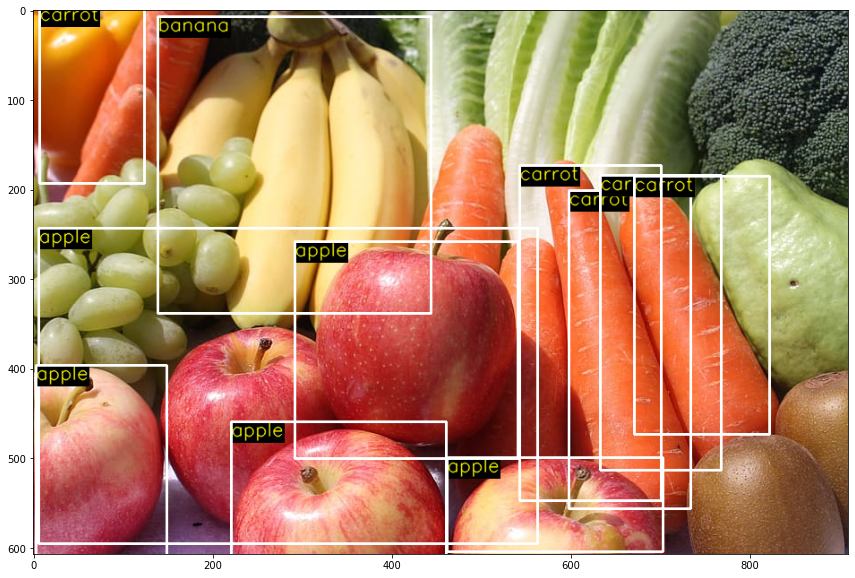

In [12]:
result = draw_objects(food_img.copy(), food_objects, 0.4)
plt.figure(figsize=(30, 10)); plt.imshow(result); plt.show();

## <font style="color:rgb(50,120,229)">4.3 Comparing confidence thresholds</font>

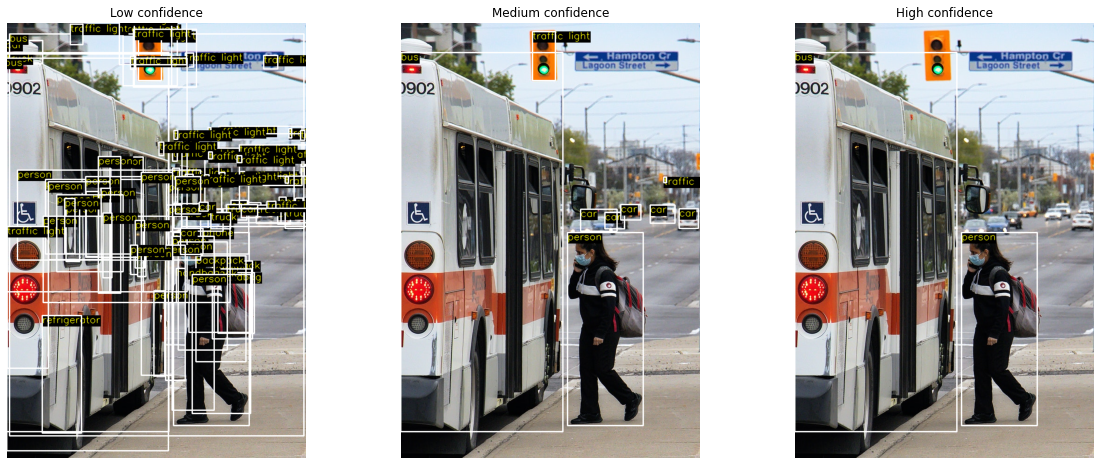

In [13]:
traffic_img = cv2.imread('traffic.jpg')
traffic_objects = detect_objects(net, traffic_img)

# Compare displays with low and high confidence thresholds.
low = draw_objects(traffic_img.copy(), traffic_objects, 0.0)
mid = draw_objects(traffic_img.copy(), traffic_objects, 0.3)
high = draw_objects(traffic_img.copy(), traffic_objects, 0.9)

# Display the different thresholds.
plt.figure(figsize = (20, 8))
plt.subplot(131); plt.axis('off'); plt.imshow(low); plt.title('Low confidence')
plt.subplot(132); plt.axis('off'); plt.imshow(mid); plt.title('Medium confidence')
plt.subplot(133); plt.axis('off'); plt.imshow(high); plt.title('High confidence')

# 5. Use a different Model from Tensorflow
What if you wanted to use a different model from Tensorflow in OpenCV? Just follow the steps given below.

### <font style="color:rgb(8,133,37)">1. Check out the Tensorflow model ZOO</font>

Model files can be downloaded from the Tensorflow Object Detection Model Zoo
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md

In our case we are using the SSD Mobilenet v2 COCO (ssd_mobilenet_v2_coco).

### <font style="color:rgb(8,133,37)">2. Download model file</font>
You can download the model file as a zip archive. For example, for the above example, we download the following file:
http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz

### <font style="color:rgb(8,133,37)">Folder Structure </font>
After you uncompress the zip file, it should look similar to this:

**ssd_mobilenet_v2_coco_2018_03_29** <br>
|─ checkpoint <br>
|─ **frozen_inference_graph.pb** <br>
|─ model.ckpt.data-00000-of-00001 <br>
|─ model.ckpt.index <br>
|─ model.ckpt.meta <br>
|─ pipeline.config <br>
|─ saved_model <br>
|─── saved_model.pb <br>
|─── variables <br>

The "frozen" .pb file is the one that is to be used in OpenCV which contains the frozen weights, meaning it only contains the information needed for inference and thus is the most lightweight.

### <font style="color:rgb(8,133,37)">3. Create config file from frozen graph</font>
If you need to create a config file to be used alog with the model file, then just run the [tf_text_graph_ssd.py](https://github.com/opencv/opencv/blob/master/samples/dnn/tf_text_graph_ssd.py) file with input as the path to the frozen_graph.pb file and output as desired.

Once you have the .pb file and .pbtxt file, you should be able to use them in OpenCV. 